In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.utils import shuffle
from joblib import dump as j_dump
from joblib import load as j_load
import time
import random
import os

In [2]:
# # Uncomment this box if the file is in google drive
# # Create your own direcotry in your google drive and change path2root var.
# path2root = "/content/drive/MyDrive/Projects/EyeTracker/"

In [3]:
# Uncomment this box if the file is in your local directory
path2root = "../../"

In [4]:
models_fol = "models/"
models_et_fol = "et/"
raw_fol = "raw/"
trained_fol = "trained/"
selected_model_num = 1
subjects_fol = "subjects/"
sbj_scalers_boi_name = "scalers-boi.bin"
sbj_model_boi_name = "model-boi"
n_subjects = 5
data_et_fol = "data-et-clb/"
chosen_inputs = [0, 1, 2, 6, 7, 8, 9]
n_subjects = 5
r_train = 0.85
n_epochs = 2
patience = 1
min_brightness_ratio = 0.6
max_brightness_ratio = 1.6

In [5]:
x1_load = []
x2_load = []
y_load = []
subjects_dir = path2root + subjects_fol

for sbj in range(1, n_subjects+1):
    sbj_dir = subjects_dir + f"{sbj}/"
    sbj_model_boi_dir = sbj_dir + sbj_model_boi_name
    sbj_scalers_boi_dir = sbj_dir + sbj_scalers_boi_name
    data_et_dir = sbj_dir + data_et_fol
    
    with open(data_et_dir + "x1.pickle", "rb") as f:
        sbj_x1_load = pickle.load(f)
    with open(data_et_dir + "x2.pickle", "rb") as f:
        sbj_x2_load = pickle.load(f)
    with open(data_et_dir + "y.pickle", "rb") as f:
        sbj_y_load = pickle.load(f)
    
    sbj_x2_chs_inp = sbj_x2_load[:, chosen_inputs]
    sbj_scalers_boi = j_load(sbj_scalers_boi_dir)
    sbj_x1_scaler_boi, sbj_x2_scaler_boi = sbj_scalers_boi
    sbj_x1 = sbj_x1_load / sbj_x1_scaler_boi
    sbj_x2 = sbj_x2_scaler_boi.transform(sbj_x2_chs_inp)
    
    sbj_model_boi = load_model(sbj_model_boi_dir)
    
    sbj_yhat_boi = sbj_model_boi.predict([sbj_x1, sbj_x2]).argmax(1)
    
    for (x10, x20, y0, yht0) in zip(sbj_x1_load, sbj_x2_load, sbj_y_load, sbj_yhat_boi):
        if True:  # yht0 != 0:
            x1_load.append(x10)
            x2_load.append(x20)
            y_load.append(y0)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_smp, frame_h, frame_w = x1_load.shape[:-1]
print(n_smp, frame_h, frame_w)

24500 48 44


In [6]:
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(min_brightness_ratio, max_brightness_ratio)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [7]:
x2_chs_inp = x2_load[:, chosen_inputs]

In [8]:
import matplotlib.pyplot as plt

[-2.92097984  0.01450496 -0.1692337   0.51821423  0.47875661  0.51987594
  0.49142322]
[2995.  948.]


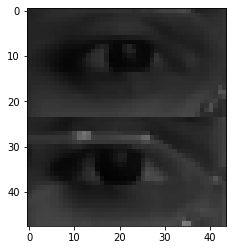

In [9]:
smp_num = 2
print(x2_chs_inp[smp_num])
print(y_load[smp_num])
plt.imshow(x1_chg_bri[smp_num].reshape((frame_h, frame_w)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [10]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers = [x1_scaler, x2_scaler, y_scalers]

In [11]:
x1_shf, x2_shf, y_hrz_shf, y_vrt_shf = shuffle(x1, x2, y[:, 0], y[:, 1])

n_train = int(r_train * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_hrz_train, y_vrt_train = y_hrz_shf[:n_train], y_vrt_shf[:n_train]
y_hrz_test, y_vrt_test = y_hrz_shf[n_train:], y_vrt_shf[n_train:]

x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]

print(x1_train.shape, x1_test.shape, y_hrz_train.shape, y_hrz_test.shape,
      x2_train.shape, x2_test.shape, y_vrt_train.shape, y_vrt_test.shape)

(20825, 48, 44, 1) (3675, 48, 44, 1) (20825,) (3675,) (20825, 7) (3675, 7) (20825,) (3675,)


In [12]:
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

In [13]:
raw_models_dir = path2root + models_fol + models_et_fol + raw_fol
model_hrz = load_model(raw_models_dir + f"model{selected_model_num}-hrz")
model_vrt = load_model(raw_models_dir + f"model{selected_model_num}-vrt")
print(model_hrz.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [14]:
results_hrz = model_hrz.fit(x_train_list,
                            y_hrz_train,
                            validation_data=(x_test_list, y_hrz_test),
                            epochs=n_epochs,
                            callbacks=cb)

Epoch 1/2
651/651 [==============================] - 29s 43ms/step - loss: 0.1438 - val_loss: 0.0830
Epoch 2/2
651/651 [==============================] - 27s 42ms/step - loss: 0.0767 - val_loss: 0.0777


In [15]:
results_vrt = model_vrt.fit(x_train_list,
                            y_vrt_train,
                            validation_data=(x_test_list, y_vrt_test),
                            epochs=n_epochs,
                            callbacks=cb)

Epoch 1/2
651/651 [==============================] - 28s 42ms/step - loss: 0.3695 - val_loss: 0.3188
Epoch 2/2
651/651 [==============================] - 28s 43ms/step - loss: 0.3023 - val_loss: 0.2992


In [16]:
y_hrz_hat_train = model_hrz.predict(x_train_list).reshape((n_train,))
y_hrz_hat_test = model_hrz.predict(x_test_list).reshape((n_test,))
y_vrt_hat_train = model_vrt.predict(x_train_list).reshape((n_train,))
y_vrt_hat_test = model_vrt.predict(x_test_list).reshape((n_test,))

In [17]:
min_out_ratio = 0.005
min_out_ratio = 0.995

y_hrz_hat_train[y_hrz_hat_train < min_out_ratio] = min_out_ratio
y_hrz_hat_test[y_hrz_hat_test < min_out_ratio] = min_out_ratio
y_vrt_hat_train[y_vrt_hat_train < min_out_ratio] = min_out_ratio
y_vrt_hat_test[y_vrt_hat_test < min_out_ratio] = min_out_ratio

y_hrz_hat_train[y_hrz_hat_train > min_out_ratio] = min_out_ratio
y_hrz_hat_test[y_hrz_hat_test > min_out_ratio] = min_out_ratio
y_vrt_hat_train[y_vrt_hat_train > min_out_ratio] = min_out_ratio
y_vrt_hat_test[y_vrt_hat_test > min_out_ratio] = min_out_ratio

Train
(3594, 474)
(3576, 1886)
Test
(599, 948)
(3576, 1886)


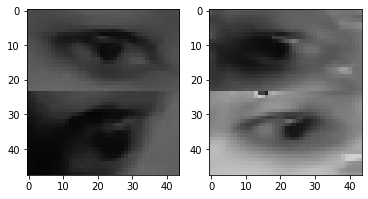

In [18]:
NUM = 1
print("Train")
sample_train = (int(y_hrz_train[NUM] * y_scalers[0]),
                int(y_vrt_train[NUM] * y_scalers[1]))
sample_train_hat = (int(y_hrz_hat_train[NUM] * y_scalers[0]),
                    int(y_vrt_hat_train[NUM] * y_scalers[1]))
print(sample_train)
print(sample_train_hat)

print("Test")
sample_test = (int(y_hrz_test[NUM] * y_scalers[0]),
                int(y_vrt_test[NUM] * y_scalers[1]))
sample_test_hat = (int(y_hrz_hat_test[NUM] * y_scalers[0]),
                    int(y_vrt_hat_test[NUM] * y_scalers[1]))
print(sample_test)
print(sample_test_hat)

_, ax = plt.subplots(1,2)
ax[0].imshow((x1_train[NUM] * x1_scaler).astype(np.uint8).
           reshape((frame_h, frame_w)), cmap="gray",vmin=0, vmax=255)
ax[1].imshow((x1_test[NUM] * x1_scaler).astype(np.uint8).
           reshape((frame_h, frame_w)), cmap="gray",vmin=0, vmax=255)

In [19]:
# train_loss = np.abs(y_train - yhat_train).sum(0) / n_train
# test_loss = np.abs(y_test - yhat_test).sum(0) / n_test

In [20]:
trained_dir = path2root + models_fol + models_et_fol + trained_fol
if not os.path.exists(trained_dir):
    os.mkdir(trained_dir)

In [21]:
models_numbers = []
models_name = os.listdir(trained_dir)
if models_name:
    for mn in models_name:
        if mn[:5] == "model":
            mn0 = int(mn[5:6])
            models_numbers.append(mn0)
    max_num = max(models_numbers)
else:
    max_num = 0

model_hrz.save(trained_dir + f"model{max_num+1}-hrz")
model_vrt.save(trained_dir + f"model{max_num+1}-vrt")

scalers_dir = path2root + models_fol + models_et_fol + trained_fol + f"scalers{max_num+1}.bin"
j_dump(scalers, scalers_dir)

INFO:tensorflow:Assets written to: ../../models/et/trained/model2-hrz\assets
INFO:tensorflow:Assets written to: ../../models/et/trained/model2-vrt\assets


['../../models/et/trained/scalers2.bin']